In [2]:
# Loading all related libraries 
import os
import math
import random
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import pytz as tz
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, jaccard_score
from sklearn.metrics import recall_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import folium
from folium import plugins
from folium.features import DivIcon
import haversine as hs
from haversine import Unit


import warnings
warnings.filterwarnings('ignore')

In [3]:
# Uploading data and loading it into 'df' dataframe
df = pd.read_csv("Gowalla_totalCheckins.txt", sep='\t',header=None)

In [4]:
# Renaming the columns as 
df.columns =['user_id', 'check_in_time', 'latitude', 'longitude','location_id']
df.head()

,user_id,check_in_time,latitude,longitude,location_id
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878


In [5]:
# Creating a new df with required columns
df_new = df[['user_id','latitude','longitude']]

# **Location Based Differential Privacy Method**

This privacy protection method sets an accurate representation of protecting the user's geolocation within radius r and depends on the privacy parameter e which decide the privacy level based on r, and is consistent with the standard version of the known differential privacy protection concept. In addition, we introduce a method to achieve geo-separation by adding randomly 
controlled noise to the user region. This method of privacy based on geo segmentation ensures without compromising the quality of application results.

https://arxiv.org/pdf/1212.1984.pdf

In [6]:
# taking a sub data frame of 30000 rows only
df_new_cpy = df_new[:30000]
df_new_cpy

,user_id,latitude,longitude
0,0,30.235909,-97.795140
1,0,30.269103,-97.749395
2,0,30.255731,-97.763386
3,0,30.263418,-97.757597
4,0,30.274292,-97.740523
...,...,...,...
29995,130,37.798669,-122.445795
29996,130,37.802901,-122.448442
29997,130,37.783828,-122.482909
29998,130,37.784107,-122.481718


### Creating the function for finding new points
find_new_points_dp(df,circle_r,e) --- Function to find out the new location points (latitude and longitude) for the old location points(latitude and longitude)<br>
df --- Dataframe <br>
circle_r --- Radius under which point is to be find out (it must be in km)<br>
e --- Privacy parameter( for best use its value is 0.01)

In [7]:
# Function to finding new point 
def find_new_points_dp(df,circle_r,e):
    
    new_lat = []
    new_lon = []
    for i in range(len(df)):
        r, theta = circle_r * math.sqrt(random.random()), 2*math.pi*random.random()
    
        nlat = df.iloc[i]['latitude'] + r * math.cos(theta)*e
        nlong = df.iloc[i]['longitude'] + r * math.sin(theta)*e 
        new_lat.append(nlat)
        new_lon.append(nlong)
    return new_lat,new_lon

In [8]:
circle_r = 0.5 # In kms
e = 0.01
new_lat, new_lon = find_new_points_dp(df_new_cpy[['latitude','longitude']],circle_r,e)

In [9]:
# Copying the new latitude and new longitude into the df_new_cpy dataframe
df_new_cpy['new_latitude'] = new_lat
df_new_cpy['new_longitude'] = new_lon

In [10]:
df_new_cpy

,user_id,latitude,longitude,new_latitude,new_longitude
0,0,30.235909,-97.795140,30.233712,-97.791855
1,0,30.269103,-97.749395,30.269854,-97.744977
2,0,30.255731,-97.763386,30.251555,-97.763186
3,0,30.263418,-97.757597,30.266809,-97.756371
4,0,30.274292,-97.740523,30.272369,-97.737350
...,...,...,...,...,...
29995,130,37.798669,-122.445795,37.799398,-122.447228
29996,130,37.802901,-122.448442,37.798552,-122.450777
29997,130,37.783828,-122.482909,37.778904,-122.482218
29998,130,37.784107,-122.481718,37.782952,-122.485378


In [11]:
# creating separet dataframe to finding out the difference in privacy and confusion matrix
df_new_cpy_without_dp = df_new_cpy[['user_id','latitude','longitude']]
df_new_cpy_with_dp = df_new_cpy[['user_id','new_latitude','new_longitude']]


In [12]:
# Dividing the Data in 20:80 percentage for testing and training purpose for the original latitude and longitude respectively
X_train_without_dp, X_test_without_dp, y_train_without_dp, y_test_without_dp = train_test_split(
    df_new_cpy_without_dp.drop('user_id', axis=1), df_new_cpy_without_dp['user_id'],
    test_size=0.20, random_state=17)

In [13]:
# Create Decision Tree classifer object for the original latitude and longitude
clf_without_dp = DecisionTreeClassifier()

# Train Decision Tree Classifer for the original latitude and longitude
clf_without_dp = clf_without_dp.fit(X_train_without_dp,y_train_without_dp)

# Predict the response for test dataset for the original latitude and longitude
y_pred_without_dp = clf_without_dp.predict(X_test_without_dp)

# Performance matrics for the original latitude and longitude
print("Performance Matrics for Original Locations \n")
print("Confusion Matrix : ", confusion_matrix(y_test_without_dp, y_pred_without_dp))
print("F1 Score: ", f1_score(y_test_without_dp, y_pred_without_dp, average='macro'))
print("Precision: ",precision_score(y_test_without_dp, y_pred_without_dp, average='macro'))
print("Recall Score: ",recall_score(y_test_without_dp, y_pred_without_dp, average='macro'))
print("Jaccard Score: ", jaccard_score(y_test_without_dp, y_pred_without_dp, average='macro'))
print("Accuracy: ", accuracy_score(y_test_without_dp, y_pred_without_dp))

Performance Matrics for Original Locations 

Confusion Matrix :  [[  4   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0 374 ...   0   0   0]
 ...
 [  0   0   1 ...  15   0   1]
 [  0   0   0 ...   0   3   0]
 [  0   0   2 ...   0   4 113]]
F1 Score:  0.45022917564844017
Precision:  0.458055243977086
Recall Score:  0.46662810537924304
Jaccard Score:  0.3445202293681434
Accuracy:  0.609


In [14]:
# Dividing the Data in 20:80 percentage for testing and training purpose for the new latitude and new longitude respectively
X_train_with_dp, X_test_with_dp, y_train_with_dp, y_test_with_dp = train_test_split(
    df_new_cpy_with_dp.drop('user_id', axis=1), df_new_cpy_with_dp['user_id'],
    test_size=0.20, random_state=17)


In [15]:
# Create Decision Tree classifer object for the new latitude and new longitude
clf_with_dp = DecisionTreeClassifier()

# Train Decision Tree Classifer for the new latitude and new longitude
clf_with_dp = clf_with_dp.fit(X_train_with_dp,y_train_with_dp)

#Predict the response for test dataset for the new latitude and new longitude
y_pred_with_dp = clf_with_dp.predict(X_test_with_dp)

#Performance Matrics for the new latitude and new longitude
print("Performance Matrics for New Locations \n")
print("Confusion Matrix : ", confusion_matrix(y_test_with_dp, y_pred_with_dp))
print("F1 Score: ", f1_score(y_test_with_dp, y_pred_with_dp, average='macro'))
print("Precision: ",precision_score(y_test_with_dp, y_pred_with_dp, average='macro'))
print("Recall Score: ",recall_score(y_test_with_dp, y_pred_with_dp, average='macro'))
print("Jaccard Score: ", jaccard_score(y_test_with_dp, y_pred_with_dp, average='macro'))
print("Accuracy: ", accuracy_score(y_test_with_dp, y_pred_with_dp))

Performance Matrics for New Locations 

Confusion Matrix :  [[  1   0   1 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0 346 ...   0   0   1]
 ...
 [  0   0   1 ...  11   0   0]
 [  0   0   0 ...   0   1   1]
 [  0   0   2 ...   1   2  98]]
F1 Score:  0.34809737312052047
Precision:  0.3535745798156987
Recall Score:  0.35277772756644776
Jaccard Score:  0.26220583019490784
Accuracy:  0.49216666666666664


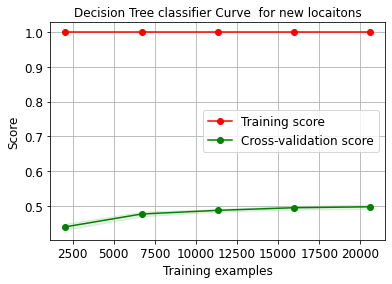

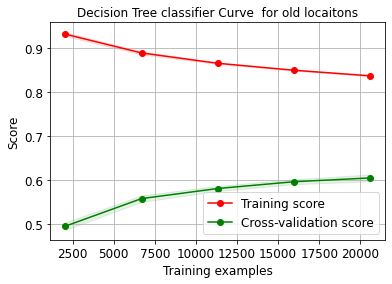

In [17]:
# # comparison between Decision Tree classification model between new and old locations
skplt.estimators.plot_learning_curve(clf_with_dp, X_train_with_dp, y_train_with_dp,
                                     cv=7, shuffle=True, scoring="accuracy", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree classifier Curve  for new locaitons");

skplt.estimators.plot_learning_curve(clf_without_dp, X_train_without_dp, y_train_without_dp,
                                     cv=7, shuffle=True, scoring="accuracy", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree classifier Curve  for old locaitons");
plt.show()

In [18]:
# Creating map object for Differential Privacy method
m_dp = folium.Map(location=[30.266666,-97.733330], zoom_start=15)

In [19]:
# Creating a circle on map for the for the original location as Client (yellow color circle)
for i in range(0,20):   
    folium.Circle(
      location=[df_new_cpy.iloc[i]['latitude'], df_new_cpy.iloc[i]['longitude']],
      popup=str(df_new_cpy.iloc[i]['user_id']),
      radius=500,
      color='yellow',
      fill=True,
      fill_color='yellow'
   ).add_to(m_dp)

In [20]:
# Creating a Marker for the for the original location as Client (Red color marker)
j = 1
for i in range(0,20):
    tooltip = 'a' + str(j)
    folium.Marker(
    location=[df_new_cpy.iloc[i]['latitude'], df_new_cpy.iloc[i]['longitude']],
    popup="client location",
    icon=folium.Icon(color="red", icon="info-sign"),
    tooltip=tooltip
).add_to(m_dp)
    j = j+1

In [21]:
# Creating a Marker for the for the new location as crowdsourcing workers(Green color marker)
k = 1
for i in range(0,20):
    tooltip = 'p' + str(k)
    folium.Marker(
    location=[df_new_cpy.iloc[i]['new_latitude'], df_new_cpy.iloc[i]['new_longitude']],
    popup="CS-Worker location",
    icon=folium.Icon(color="green", icon="info-sign"),
    tooltip=tooltip
).add_to(m_dp)
    k = k +1


In [22]:
print("Demo Representation")
m_dp

Demo Representation


#  **Privacy-Preserving Method Based on Historical Proximity Location**

The main idea of how to Preserve Privacy According to Proximity Location History is to place in one existing historical location near the current location user. This method ensures that the user can access location-based services without submitting actual location information, which can improve the level of privacy while reducing counting and communication on the server side. In addition, this method can not only provide privacy protection for query questions but also protects the privacy of the trajectory from furtherance. Compared to other privacy measures such as anonymity and dummy location, this method improves the quality and performance of the query while maintaining a satisfactory confidentiality level.

https://www.hindawi.com/journals/wcmc/2020/8892079/

In [23]:
# taking a sub data frame of 20000 rows only for Historical Proximity method
hp_df_new_cpy = df_new[:20000]

In [24]:
hp_df_new_cpy

,user_id,latitude,longitude
0,0,30.235909,-97.795140
1,0,30.269103,-97.749395
2,0,30.255731,-97.763386
3,0,30.263418,-97.757597
4,0,30.274292,-97.740523
...,...,...,...
19995,101,42.357491,-71.058885
19996,101,42.357437,-71.058470
19997,101,42.357553,-71.057779
19998,101,42.357142,-71.058455


### Creating the function for finding new points
find_new_points_hp(df,hp) --- Function to find out the new location points (latitude and longitude) for the old location points(latitude and longitude) on the basis of Historical Proximity <br>
df --- Dataframe <br>
hp --- Historical Privacy parameter( in this case it is 1)

In [25]:
# Creating a function to find out the new location on the basis of Historical Proximity haping historical privacy parameter hp
def find_new_points_hp(df, hp):
    hp_new_lat = []
    hp_new_lon = []
    for i in range(len(df)):
        if df.iloc[i]['user_id'] == df.iloc[i-hp]['user_id'] :
            hp_new_lat.append(df.iloc[i-hp]['latitude'])
            hp_new_lon.append(df.iloc[i-hp]['longitude'])
        else:
            hp_new_lat.append(df.iloc[i]['latitude'])
            hp_new_lon.append(df.iloc[i]['longitude'])
    return hp_new_lat,hp_new_lon



In [26]:
hp = 1
hp_new_lat, hp_new_lon = find_new_points_hp(hp_df_new_cpy,hp)

In [27]:
# Copying the new latitude and new longitude into the hp_df_new_cpy dataframe
hp_df_new_cpy['new_latitude'] = hp_new_lat
hp_df_new_cpy['new_longitude'] = hp_new_lon

In [28]:
hp_df_new_cpy

,user_id,latitude,longitude,new_latitude,new_longitude
0,0,30.235909,-97.795140,30.235909,-97.795140
1,0,30.269103,-97.749395,30.235909,-97.795140
2,0,30.255731,-97.763386,30.269103,-97.749395
3,0,30.263418,-97.757597,30.255731,-97.763386
4,0,30.274292,-97.740523,30.263418,-97.757597
...,...,...,...,...,...
19995,101,42.357491,-71.058885,42.357910,-71.058144
19996,101,42.357437,-71.058470,42.357491,-71.058885
19997,101,42.357553,-71.057779,42.357437,-71.058470
19998,101,42.357142,-71.058455,42.357553,-71.057779


In [29]:
# creating separet dataframe to finding out the difference in privacy and confusion matrix
df_new_cpy_without_hp = hp_df_new_cpy[['user_id','latitude','longitude']]
df_new_cpy_with_hp = hp_df_new_cpy[['user_id','new_latitude','new_longitude']]

In [30]:
# Dividing the Data in 20:80 percentage for testing and training purpose for the original latitude and original longitude respectively
X_train_without_hp, X_test_without_hp, y_train_without_hp, y_test_without_hp = train_test_split(
    df_new_cpy_without_hp.drop('user_id', axis=1), df_new_cpy_without_hp['user_id'],
    test_size=0.20, random_state=17)

In [31]:
# Create Decision Tree classifer object for the original latitude and original longitude respectively
clf_without_hp = DecisionTreeClassifier()

# Train Decision Tree Classifer for the original latitude and original longitude respectively
clf_without_hp = clf_without_hp.fit(X_train_without_hp,y_train_without_hp)

# Predict the response for test dataset for the original latitude and original longitude respectively
y_pred_without_hp = clf_without_hp.predict(X_test_without_hp)

# Performance matrics for the original latitude and longitude
print(" Performance matrics for the original locations \n")
print("Confusion Matrix : ", confusion_matrix(y_test_without_hp, y_pred_without_hp))
print("F1 Score: ", f1_score(y_test_without_hp, y_pred_without_hp, average='macro'))
print("Precision: ",precision_score(y_test_without_hp, y_pred_without_hp, average='macro'))
print("Recall Score: ",recall_score(y_test_without_hp, y_pred_without_hp, average='macro'))
print("Jaccard Score: ", jaccard_score(y_test_without_hp, y_pred_without_hp, average='macro'))
print("Accuracy: ", accuracy_score(y_test_without_hp, y_pred_without_hp))

 Performance matrics for the original locations 

Confusion Matrix :  [[  6   0   0 ...   0   0   0]
 [  0   0   0 ...   0   1   0]
 [  0   0 394 ...   0   0   0]
 ...
 [  0   0   0 ...  10   0   0]
 [  0   0   0 ...   1  52   0]
 [  0   0   0 ...   0   0  77]]
F1 Score:  0.47460546929275566
Precision:  0.5043830266843463
Recall Score:  0.466120167415345
Jaccard Score:  0.3718581354014481
Accuracy:  0.65825


In [32]:
# Dividing the Data in 20:80 percentage for testing and training purpose for the new latitude and new longitude respectively
X_train_with_hp, X_test_with_hp, y_train_with_hp, y_test_with_hp = train_test_split(
    df_new_cpy_with_hp.drop('user_id', axis=1), df_new_cpy_with_hp['user_id'],
    test_size=0.20, random_state=17)

In [33]:
# Create Decision Tree classifer object for the new latitude and new longitude
clf_with_hp = DecisionTreeClassifier()

# Train Decision Tree Classifer for the new latitude and new longitude
clf_with_hp = clf_with_hp.fit(X_train_with_hp,y_train_with_hp)

# Predict the response for test dataset for the new latitude and new longitude
y_pred_with_hp = clf_with_hp.predict(X_test_with_hp)

# Performance matrics for the new latitude and longitude
print(" Performance matrics for the new Locations \n")
print("Confusion Matrix : ", confusion_matrix(y_test_with_hp, y_pred_with_hp))
print("F1 Score: ", f1_score(y_test_with_hp, y_pred_with_hp, average='macro'))
print("Precision: ",precision_score(y_test_with_hp, y_pred_with_hp, average='macro'))
print("Recall Score: ",recall_score(y_test_with_hp, y_pred_with_hp, average='macro'))
print("Jaccard Score: ", jaccard_score(y_test_with_hp, y_pred_with_hp, average='macro'))
print("Accuracy: ", accuracy_score(y_test_with_hp, y_pred_with_hp))

 Performance matrics for the new Locations 

Confusion Matrix :  [[  9   0   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]
 [  0   0 407 ...   0   0   0]
 ...
 [  0   0   0 ...  13   0   0]
 [  0   0   0 ...   0  46   0]
 [  3   0   2 ...   2   0  77]]
F1 Score:  0.5042994389222925
Precision:  0.5232181139039028
Recall Score:  0.5198606421966552
Jaccard Score:  0.39285811601815646
Accuracy:  0.64975


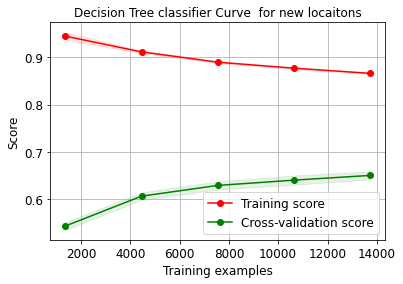

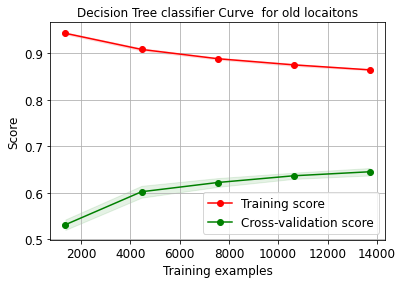

In [34]:
# comparison between Decision Tree classification model between new and old locations
skplt.estimators.plot_learning_curve(clf_with_hp, X_train_with_hp, y_train_with_hp,
                                     cv=7, shuffle=True, scoring="accuracy", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree classifier Curve  for new locaitons");

skplt.estimators.plot_learning_curve(clf_without_hp, X_train_without_hp, y_train_without_hp,
                                     cv=7, shuffle=True, scoring="accuracy", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree classifier Curve  for old locaitons");
plt.show()

In [35]:
# Creating map object for Historical Proximity Privacy method
m_hp = folium.Map(location=[30.266666,-97.733330], zoom_start=15)

In [36]:
# Creating a circle on map for the for the original location as Client (yellow color circle)
for i in range(0,50,2):   
    folium.Circle(
      location=[hp_df_new_cpy.iloc[i]['latitude'], hp_df_new_cpy.iloc[i]['longitude']],
      popup=str(int(hp_df_new_cpy.iloc[i]['user_id'])),
      radius=500,
      color='yellow',
      fill=True,
      fill_color='yellow'
   ).add_to(m_hp)

In [37]:
# Creating a Marker for the for the original location as Client (Red color marker)
j = 1
for i in range(0,50,2):
    tooltip = 'a' + str(j)
    folium.Marker(
    location=[hp_df_new_cpy.iloc[i]['latitude'], hp_df_new_cpy.iloc[i]['longitude']],
    popup="client location",
    icon=folium.Icon(color="red", icon="info-sign"),
    tooltip=tooltip
   ).add_to(m_hp)
    j = j+1

In [38]:
# Creating a Marker for the for the new location as Croud Source Worker (Red color marker)
k = 1
for i in range(0,50,2):
    tooltip = 'p' + str(k)
    folium.Marker(
    location=[hp_df_new_cpy.iloc[i]['new_latitude'], hp_df_new_cpy.iloc[i]['new_longitude']],
    popup="CS-Worker location",
    icon=folium.Icon(color="green", icon="info-sign"),
    tooltip=tooltip
  ).add_to(m_hp)
    k = k +1

In [39]:
print("Demo Representation")
m_hp

Demo Representation


# **Predictive Differentially-Private Mechanism**
In this method the authors show that the sequence convergence can actually be used by a predictive function that attempts to predict a new location based on previously reported locations. The proposed method assesses the quality of the predicted area using private inspections; in the event of a success the prediction is reported otherwise the location is acquired with new sound. If there is a significant correlation in the follow-up to the installation, additional testing costs are small compared to the budget savings, which leads to more efficiency. Here We explore the process in terms of getting a locally based service while roaming the city. Using a simple predictive function and a geo-indistinguishability scheme, we show that the predictive method can offer greater improvements than noise used independently.


https://arxiv.org/pdf/1311.4008.pdf

In [40]:
# Taking the sub dataframe of df for Predictive Differentially-Private Mechanism
ppm_df_new_cpy = df[:25000]

In [41]:
# droping the check_in_time columns
ppm_df_new_cpy = ppm_df_new_cpy.drop('check_in_time',axis=1,errors='ignore')

In [42]:
ppm_df_new_cpy

,user_id,latitude,longitude,location_id
0,0,30.235909,-97.795140,22847
1,0,30.269103,-97.749395,420315
2,0,30.255731,-97.763386,316637
3,0,30.263418,-97.757597,16516
4,0,30.274292,-97.740523,5535878
...,...,...,...,...
24995,116,30.389965,-97.733088,14737
24996,116,30.415158,-97.744128,48573
24997,116,30.414571,-97.746626,22163
24998,116,30.318528,-97.724378,16495


In [43]:
kmeans = KMeans(n_clusters=500, init='k-means++')

# Compute the clusters based on longitude and latitude features
X_sample = ppm_df_new_cpy[['longitude','latitude']].sample(frac=1)
kmeans.fit(X_sample)
y = kmeans.labels_
print("k = 500", " silhouette_score ", silhouette_score(X_sample, y, metric='euclidean'))

k = 500  silhouette_score  0.552642748220431


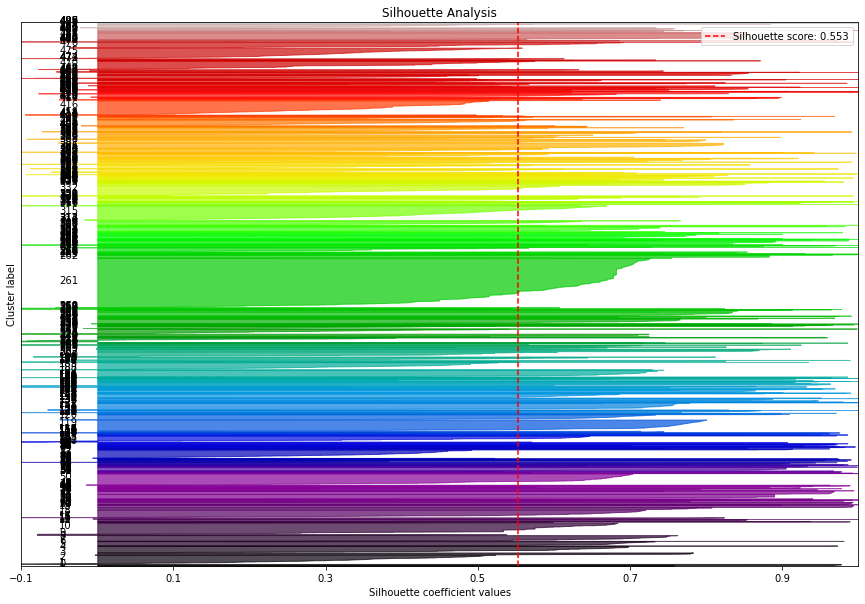

In [44]:
cluster_labels = y
skplt.metrics.plot_silhouette(X_sample, cluster_labels, figsize=(15,10));
plt.show()

In [45]:
# Copying the Cluster into the ppm_df_new_cpy dataframe as new column
ppm_df_new_cpy['cluster'] = kmeans.predict(ppm_df_new_cpy[['longitude','latitude']])

In [46]:
ppm_df_new_cpy

,user_id,latitude,longitude,location_id,cluster
0,0,30.235909,-97.795140,22847,362
1,0,30.269103,-97.749395,420315,261
2,0,30.255731,-97.763386,316637,470
3,0,30.263418,-97.757597,16516,470
4,0,30.274292,-97.740523,5535878,261
...,...,...,...,...,...
24995,116,30.389965,-97.733088,14737,103
24996,116,30.415158,-97.744128,48573,103
24997,116,30.414571,-97.746626,22163,103
24998,116,30.318528,-97.724378,16495,476


### Creating the pridiction function for finding new points
new_points_prediciton(l, df, latitude, longitude) --- Function to find out the new location points (latitude and longitude) for the old location points(latitude and longitude) on the basis of prediction or geo-indistinguishability depending upon l (radial distance ) <br>
l --- Radial distance from the original location(it must be in meter)<br/>
df --- Dataframe <br>
latitude ---  Latitude of original location<br/>
longitude --- Longitude of original locaiton<br/>
e --- privacy parameter (Here it is 0.01 for best use)


In [47]:
# function for prediction of new location based on clustering
def new_point_prediction(l, df, latitude, longitude):
    predicted_cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    # Fetch the venue name of the top most record in the topvenues dataframe for the predicted cluster
  
    ppm_lat = df[df['cluster']==predicted_cluster].iloc[0]['latitude']
    ppm_lon = df[df['cluster']==predicted_cluster].iloc[0]['longitude']
    loc1 = (ppm_lat, ppm_lon)
    loc2 = (latitude, longitude)

    if hs.haversine(loc1,loc2,unit=Unit.METERS) < l and hs.haversine(loc1,loc2,unit=Unit.METERS) != 0 :
        return ppm_lat, ppm_lon
    else:
        return noised_point(l, latitude, longitude)
  
 

In [48]:
# function for prediction of new location based on noise
def noised_point(l, latitude, longitude):
    e = 0.01
    l = l/1000
    r, theta = l * math.sqrt(random.random()), 2*math.pi*random.random()    
    nlat = latitude + r * math.cos(theta)*e
    nlong = longitude + r * math.sin(theta)*e 
    return nlat, nlong


In [49]:
# creating new location using old location under radial distance 500 meter. 
ppm_lat = []
ppm_lon = []
l = 500
for i in range(len(ppm_df_new_cpy)):
    nlat, nlon = new_point_prediction(l,ppm_df_new_cpy,ppm_df_new_cpy.iloc[i]['latitude'],ppm_df_new_cpy.iloc[i]['longitude'])
    ppm_lat.append(nlat)
    ppm_lon.append(nlon)



In [50]:
# Copying the new latitude and new longitude into the ppm_df_new_cpy dataframe
ppm_df_new_cpy['new_latitude'] = ppm_lat
ppm_df_new_cpy['new_longitude'] = ppm_lon

In [51]:
ppm_df_new_cpy.head(20)

,user_id,latitude,longitude,location_id,cluster,new_latitude,new_longitude
0,0,30.235909,-97.795140,22847,362,30.239914,-97.792778
1,0,30.269103,-97.749395,420315,261,30.267170,-97.752461
2,0,30.255731,-97.763386,316637,470,30.254933,-97.760934
3,0,30.263418,-97.757597,16516,470,30.267531,-97.759466
4,0,30.274292,-97.740523,5535878,261,30.275224,-97.735935
5,0,30.261599,-97.758581,15372,470,30.261806,-97.757479
6,0,30.267910,-97.749312,21714,261,30.269103,-97.749395
7,0,30.269103,-97.749395,420315,261,30.271906,-97.749519
8,0,30.281120,-97.745211,153505,261,30.279005,-97.746938
9,0,30.269103,-97.749395,420315,261,30.265344,-97.750478


In [52]:
# creating separet dataframe to finding out the difference in privacy and confusion matrix
df_new_cpy_without_ppm = ppm_df_new_cpy[['user_id','latitude','longitude']]
df_new_cpy_with_ppm = ppm_df_new_cpy[['user_id','new_latitude','new_longitude']]

In [53]:
# Dividing the Data in 20:80 percentage for testing and training purpose for the original latitude and original longitude respectively
X_train_without_ppm, X_test_without_ppm, y_train_without_ppm, y_test_without_ppm = train_test_split(
    df_new_cpy_without_ppm.drop('user_id', axis=1), df_new_cpy_without_ppm['user_id'],
    test_size=0.20, random_state=42)

In [54]:
# Create Decision Tree classifer object for the original latitude and original longitude
clf_without_ppm = DecisionTreeClassifier(max_depth=15, random_state=42)

# Train Decision Tree Classifer for the original latitude and original longitude
clf_without_ppm = clf_without_ppm.fit(X_train_without_ppm,y_train_without_ppm)

#Predict the response for test dataset for the original latitude and original longitude
y_pred_without_ppm = clf_without_ppm.predict(X_test_without_ppm)

# Performance matrics for the original latitude and longitude
print("Performance matrics for the original locations \n")
print("Confusion Matrix : ", confusion_matrix(y_test_without_ppm, y_pred_without_ppm))
print("F1 Score: ", f1_score(y_test_without_ppm, y_pred_without_ppm, average='macro'))
print("Precision: ",precision_score(y_test_without_ppm, y_pred_without_ppm, average='macro'))
print("Recall Score: ",recall_score(y_test_without_ppm, y_pred_without_ppm, average='macro'))
print("Jaccard Score: ", jaccard_score(y_test_without_ppm, y_pred_without_ppm, average='macro'))
print("Accuracy: ", accuracy_score(y_test_without_ppm, y_pred_without_ppm))

Performance matrics for the original locations 

Confusion Matrix :  [[  1   0   0 ...   0   0   4]
 [  0   1   0 ...   0   0   0]
 [  0   0 382 ...   0   0   0]
 ...
 [  0   0   0 ...  33   0   0]
 [  0   0   0 ...   0  20   1]
 [  1   0   0 ...   0   0 136]]
F1 Score:  0.4674497176526725
Precision:  0.5021160866185798
Recall Score:  0.47894561159303944
Jaccard Score:  0.3616135777546445
Accuracy:  0.628


In [55]:
# Dividing the Data in 20:80 percentage for testing and training purpose for the new latitude and new longitude respectively
X_train_with_ppm, X_test_with_ppm, y_train_with_ppm, y_test_with_ppm = train_test_split(
    df_new_cpy_with_ppm.drop('user_id', axis=1), df_new_cpy_with_ppm['user_id'],
    test_size=0.20, random_state=17)

In [56]:
# Create Decision Tree classifer object for the new latitude and new longitude
clf_with_ppm = DecisionTreeClassifier()

# Train Decision Tree Classifer for the new latitude and new longitude
clf_with_ppm = clf_with_ppm.fit(X_train_with_ppm,y_train_with_ppm)

#Predict the response for test dataset for the new latitude and new longitude
y_pred_with_ppm = clf_with_ppm.predict(X_test_with_ppm)

# Performance matrics for the new latitude and longitude
print("Performance matrics for the new locations \n")
print("Confusion Matrix : ", confusion_matrix(y_test_with_ppm, y_pred_with_ppm))
print("F1 Score: ", f1_score(y_test_with_ppm, y_pred_with_ppm, average='macro'))
print("Precision: ",precision_score(y_test_with_ppm, y_pred_with_ppm, average='macro'))
print("Recall Score: ",recall_score(y_test_with_ppm, y_pred_with_ppm, average='macro'))
print("Jaccard Score: ", jaccard_score(y_test_with_ppm, y_pred_with_ppm, average='macro'))
print("Accuracy: ", accuracy_score(y_test_with_ppm, y_pred_with_ppm))

Performance matrics for the new locations 

Confusion Matrix :  [[  7   0   0 ...   0   0   1]
 [  0   0   0 ...   0   0   0]
 [  0   0 390 ...   0   0   1]
 ...
 [  0   0   0 ...  40   0   0]
 [  0   0   0 ...   0   5   0]
 [  0   0   0 ...   0   0 113]]
F1 Score:  0.37363482596028086
Precision:  0.3788024941672043
Recall Score:  0.3937176931012961
Jaccard Score:  0.27574078063643886
Accuracy:  0.547


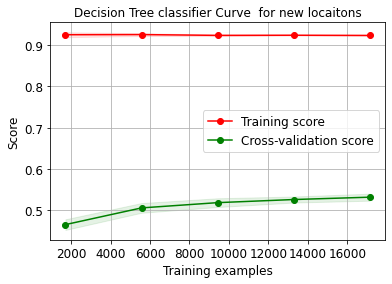

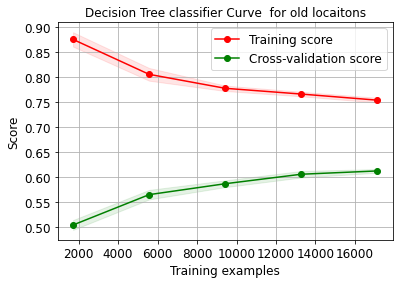

In [57]:
# comparison between Decision Tree classification model between new and old locations
skplt.estimators.plot_learning_curve(clf_with_ppm, X_train_with_ppm, y_train_with_ppm,
                                     cv=7, shuffle=True, scoring="accuracy", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree classifier Curve  for new locaitons");

skplt.estimators.plot_learning_curve(clf_without_ppm, X_train_without_ppm, y_train_without_ppm,
                                     cv=7, shuffle=True, scoring="accuracy", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree classifier Curve  for old locaitons");
plt.show()

In [58]:
# Creaing map variable
m_ppm = folium.Map(location=[30.266666,-97.733330], zoom_start=15)

In [59]:
# Creating Circle for original location with 500 meter radius for the map m_ppm (yellow color)
l = 1
for i in range(0,20):   
    folium.Circle(
      location=[ppm_df_new_cpy.iloc[i]['latitude'], ppm_df_new_cpy.iloc[i]['longitude']],
      popup=str(int(l)),
      radius=500,
      color='yellow',
      fill=True,
      fill_color='yellow'
   ).add_to(m_ppm)
    l = l+1

In [60]:
# Creating Marker for original location for the map m_ppm (Red color)
j = 1
for i in range(0,20):
    tooltip = 'a' + str(j)
    folium.Marker(
    location=[ppm_df_new_cpy.iloc[i]['latitude'], ppm_df_new_cpy.iloc[i]['longitude']],
    popup="client location",
    icon=folium.Icon(color="red", icon="info-sign"),
    tooltip=tooltip
  ).add_to(m_ppm)
    j = j+1

In [61]:
# Creating Marker for original location for the map m_ppm (Green color)
k = 1
for i in range(0,20):
    tooltip = 'p' + str(k)
    folium.Marker(
    location=[ppm_df_new_cpy.iloc[i]['new_latitude'], ppm_df_new_cpy.iloc[i]['new_longitude']],
    popup="CS-Worker location",
    icon=folium.Icon(color="green", icon="info-sign"),
    tooltip=tooltip
  ).add_to(m_ppm)
    k = k +1

In [62]:
print("Demo Representation")
m_ppm

Demo Representation
